# (Improved) Learning to Sample Ray Paths for Faster Ray Tracing

<a target="_blank" href="https://colab.research.google.com/github/jeertmans/DiffeRT2d/blob/main/docs/source/notebooks/cost20120_helsinki_improved_model.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this notebook, we present an improved version of
our Machine Learning model {cite}`learning-sample-ray-cost-2024`,
with inspiration
from the Generative Augented Flow Networks see {cite}`gaflownet`.

Our model tries to learn how to sample valid ray paths
to reduce the overall computational complexity of Ray Tracing (RT).

For more details, please refer to the
[Python notebook of the base model](./cost20120_helsinki_model.ipynb).

## Introduction

In the base model, we observed that...

In [1]:
# A few importants imports to be able to run our code
# 'type hint' related imports are only here for help documenting the code!
import jax
jax.config.update("jax_platform_name", "cpu")

try:
    import differt2d  # noqa: F401
except ImportError:
    import sys  # noqa: F401

    !{sys.executable} -m pip install git+https://github.com/jeertmans/DiffeRT2d.git

from collections.abc import Iterator
from functools import partial
from itertools import cycle

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from beartype import beartype as typechecker
from jaxtyping import Array, Float, Int, PRNGKeyArray, jaxtyped
from tqdm.notebook import trange

from differt2d.geometry import ImagePath, Point, Wall
from differt2d.logic import is_true
from differt2d.scene import Scene

In [2]:
key = jax.random.PRNGKey(12345)  # 12345 is the 'random seed'
key, key_samples = jax.random.split(key, 2)

## Training data generation

This code is a copy-paste from the base model.

In [3]:
def random_samples(
    min_ratio: float = 0.20,
    max_ratio: float = 0.40,
    min_num_walls: int = 4,
    min_angle: float = -0.1 * jnp.pi,
    max_angle: float = +0.1 * jnp.pi,
    *,
    key: PRNGKeyArray,
) -> Iterator[Float[Array, "2+num_walls*2 2"]]:
    """
    Returns a generator of random variants of :func:`Scene.square_scene_with_obstacle`.

    The generation follows a three-steps process:

    1. generate a ``square_scene_with_obstacle`` with a random scaling ratio;
    2. sample a random number of walls from this scene;
    3. and apply a random rotation around the scene's center for each wall.

    :param min_ratio: The minimum scaling ratio of the inner square obstacle.
    :param min_ratio: The maximum scaling ratio of the inner square obstacle.
    :param min_num_walls: The minimum number of walls to sample (maximum is 8).
    :param min_angle: The minimum rotation angle (random for each wall).
    :param max_angle: The maximum rotation angle (random for each wall).
    :param key: The random key to be used.
    :return: An iterator over xys samples
    """
    while True:
        key, key_ratio, key_tx_rx, key_num_walls, key_walls, key_angles = (
            jax.random.split(key, 6)
        )
        # A random scaling is applied to the inner square
        ratio = jax.random.uniform(key_ratio, minval=min_ratio, maxval=max_ratio)
        # TX and RX are randomly sampled
        points = jax.random.uniform(key_tx_rx, (2, 2))
        # The walls are samples from the scene
        scene = Scene.square_scene_with_obstacle(ratio=ratio)
        center = scene.center()
        indices = jnp.arange(len(scene.objects), dtype=jnp.int32)
        # The number of walls is random
        num_walls = jax.random.randint(
            key_num_walls, (), minval=min_num_walls, maxval=len(scene.objects) + 1
        )
        # Walls are shuffled (to make sure deepset models
        # is permutation invariant, but should not be needed)
        wall_indices = jax.random.choice(
            key_walls, indices, shape=(num_walls,), replace=False
        )
        # Each wall receives a random permutation around the center of the scene
        angles = jax.random.uniform(
            key_angles, shape=(num_walls,), minval=min_angle, maxval=max_angle
        )
        objects = [
            scene.objects[wall_index].rotate(angle=angle, around=center)
            for wall_index, angle in zip(wall_indices, angles)
        ]

        points = jnp.vstack([points, *[obj.xys for obj in objects]])

        yield points


@jax.jit
def sample_2_scene(xys: Float[Array, "2+num_walls*2 2"]) -> Scene:
    """
    Creates the scene corresponding to the given sample.

    :param xys: The sample as returned by :func:`random_samples`.
    :return: The corresponding scene.
    """
    tx = Point(xy=xys[0, :])
    rx = Point(xy=xys[1, :])

    walls = xys[2:].reshape(-1, 2, 2)
    walls = [Wall(xys=wall) for wall in walls]

    return Scene(transmitters={"tx": tx}, receivers={"rx": rx}, objects=walls)


samples = random_samples(key=key_samples)

=(random-scene-example)
### Example of random scene

Below, we can see one of the random scenes generated by our function defined just before.

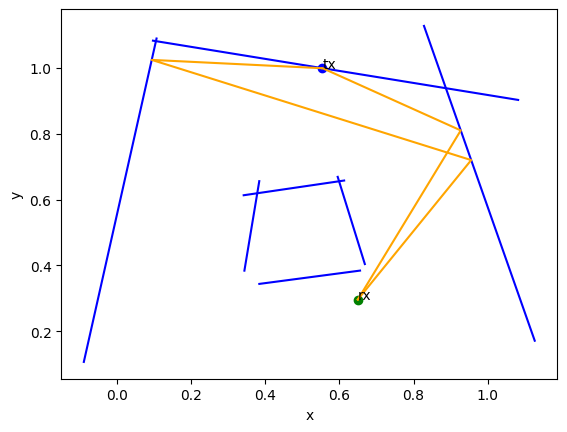

In [4]:
# Run this cell multiple times for different results!

ax = plt.gca()
scene = sample_2_scene(next(samples))
scene.plot(ax)

for _, _, path, _ in scene.all_valid_paths(order=2):
    path.plot(ax)

plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Training and validation samples

Because our data generation produces a never-ending sequence of
samples, each sample being unique, we can very well take the 100 first samples
and use them as a validation set.

Using 100 samples is a bit arbitrary, as it assumes that those 100
samples can be representative of the distribution of all possible
scenes. We will discuss that assumptions in the [discussion](#discussion)
section.

In [5]:
# Let's filter out the cases with not valid paths,
# because they are not interesting to learn from.

def filter_xys(xys: Float[Array, "2+num_walls*2 2"], order: int) -> bool:
    """
    Returns True if the scene contains at least one valid path.

    :param xys: The input scene.
    :param order: The order of the paths.
    :return: True if the scene should be kept.
    """
    scene = sample_2_scene(xys)

    for _ in scene.all_valid_paths(order=order):
        return True

    return False


order = 2

num_train_samples = 1000
num_val_samples = 100

filtered_samples = filter(partial(filter_xys, order=order), samples)

# The following can take some time as it well evaluate the lazy generator

train_samples = cycle([next(filtered_samples) for i in range(num_train_samples)])
val_samples = [next(filtered_samples) for i in range(num_val_samples)]

## Reward function

To indicate our model which path candidates should be sampled
(and which paths should not), we define a *reward* function.

The goal of the reward function is to give a high reward to valid paths,
and and a low reward to invalid ones.

The simplest reward possible is the following: valid path candidates
receive a reward of 1, while invalid path candidates receive no reward.

In [6]:
@jax.jit
@jaxtyped(typechecker=typechecker)
def reward(
    pred_path_candidate: Int[Array, "order"],
    scene: Scene,
) -> Float[Array, " "]:
    """
    Rewards a predicted path candidate depending on if it
    produces a valid path in the given scene.

    :param pred_path_candidate: The predicted path candidate.
    :param scene: The scene in which the path is traced.
    :return: The (positive) reward.
    """
    tx = scene.transmitters["tx"]
    rx = scene.receivers["rx"]

    # The following it a JIT-compatible variant of scene.get_interacting_objects
    xys = jnp.stack(
        [wall.xys for wall in scene.objects]
    )  # Stack all walls into one array
    interacting_walls = jnp.take(xys, pred_path_candidate, axis=0)
    interacting_walls = [Wall(xys=wall) for wall in interacting_walls]

    path = ImagePath.from_tx_objects_rx(tx, interacting_walls, rx)
    valid = path.is_valid(scene.objects, pred_path_candidate, interacting_walls)

    return valid.astype(float)


@jax.jit
@jaxtyped(typechecker=typechecker)
def intermediate_reward(
    intermediate_path_candidate: Int[Array, "intermediate_order"],
    scene: Scene,
    *,
    key: PRNGKeyArray,
) -> Float[Array, " "]:
    """
    Rewards an intermediate path candidate depending on if it could
    produce a valid path in the given scene.

    :param intermediate_path_candidate: The intermediate path candidate.
    :param scene: The scene in which the path is traced.
    :return: The (positive) reward.
    """
    assert intermediate_path_candidate.size > 0
    last_wall_index = intermediate_path_candidate[-1]
    last_wall = scene.get_object(last_wall_index)

    scene = scene.with_receivers(rx=last_wall.sample(key=key))

    return reward(intermediate_path_candidate[:-1], scene)

Let us take a look at the rewards of the different path candidates from the above scene.

invalid: path_candidate = [0, 1] has a reward of 0.0
invalid: path_candidate = [0, 2] has a reward of 0.0
invalid: path_candidate = [0, 3] has a reward of 0.0
invalid: path_candidate = [0, 4] has a reward of 0.0
valid  : path_candidate = [0, 5] has a reward of 1.0
invalid: path_candidate = [0, 6] has a reward of 0.0
invalid: path_candidate = [1, 0] has a reward of 0.0
invalid: path_candidate = [1, 2] has a reward of 0.0
invalid: path_candidate = [1, 3] has a reward of 0.0
invalid: path_candidate = [1, 4] has a reward of 0.0
invalid: path_candidate = [1, 5] has a reward of 0.0
invalid: path_candidate = [1, 6] has a reward of 0.0
invalid: path_candidate = [2, 0] has a reward of 0.0
invalid: path_candidate = [2, 1] has a reward of 0.0
invalid: path_candidate = [2, 3] has a reward of 0.0
invalid: path_candidate = [2, 4] has a reward of 0.0
invalid: path_candidate = [2, 5] has a reward of 0.0
invalid: path_candidate = [2, 6] has a reward of 0.0
invalid: path_candidate = [3, 0] has a reward 

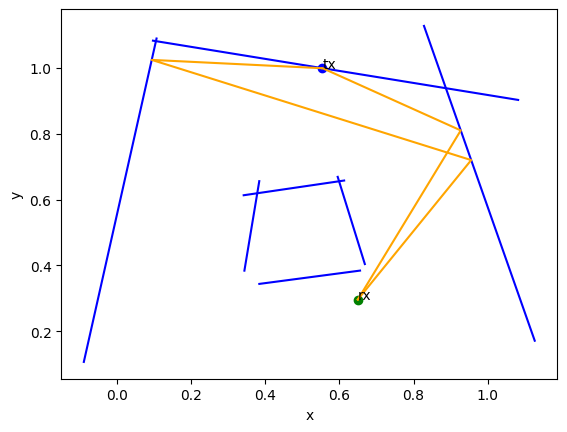

In [7]:
ax = plt.gca()
scene.plot(ax)

for _, _, valid, path, path_candidate in scene.all_paths(order=order):
    if is_true(valid):
        path.plot(ax)
        s = "valid  :"
    else:
        s = "invalid:"

    p = path_candidate.tolist()
    r = reward(path_candidate, scene)

    print(f"{s} path_candidate = {p} has a reward of {r}")

plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Model definition



In [8]:
class FlowModel(eqx.Module):
    """The flow model that returns flows between two states."""

    # Layers
    wall_2_embeddings: eqx.nn.MLP
    """MLP that is applied to each wall in parallel and
    returns the corresponding embeddings."""
    embeddings_2_flow: eqx.nn.MLP
    """MLP that maps each possible choice to some positive flow."""

    def __init__(
        self,
        # Hyperparameters
        num_embeddings: int = 100,
        *,
        key: PRNGKeyArray,
    ):
        """
        Constructs a GFlowNet model.

        :param num_embeddings: The size of the vector that will represent each wall.
        :param key: The random key to be used.
        """
        key1, key2 = jax.random.split(key, 2)

        # Layers
        self.wall_2_embeddings = eqx.nn.MLP(
            in_size=4,
            out_size=num_embeddings,
            width_size=500,
            depth=3,
            key=key1,
        )
        self.embeddings_2_flow = eqx.nn.MLP(
            in_size=4
            + 2 * num_embeddings
            + 4,  # [tx_rx, state_embeddings, scene_embeddings, wall[i]]
            out_size="scalar",
            width_size=500,
            depth=3,
            final_activation=jnp.exp,  # Positive flow only
            key=key2,
        )

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(
        self,
        state: Float[Array, "num_walls order"],
        wall_index: Int[Array, " "],
        xys: Float[Array, "2+num_walls*2 2"],
    ) -> Float[Array, "num_walls"]:
        """
        Calls this model in order to generate a new flow from a given state,
        the last selected wall index, and some input scene.

        :param state: The current state, a one-hot encoding of the path candidate
            in construction. Only one element per column can be non-zero.
        :param wall_index: The index of the last wall that was selected. A negative index
            indicates that no wall was previously selected.
        :param xys: The array of xy-coordinates, as returned by
            :func:`random_samples`.
        :return: The array of flows, one per wall in the scene.
        """
        assert (
            xys.shape[0] >= 4
        ), "Scene must at least have two points, tx and rx, and one wall!"

        num_walls, order = state.shape

        # Data normalization
        eps = 1e-5
        center = jnp.atleast_2d(xys[0, :])  # We arbitrarily put tx at the center
        std = jnp.std(xys, axis=0, keepdims=True)

        xys = (xys - center) / (std + eps)

        # Rotation invariance
        direction = xys[1, :]  # tx and rx make an horizontal line
        angle = jnp.atan2(direction[1], direction[0])
        s = jnp.sin(angle)
        c = jnp.cos(angle)
        rotation = jnp.array([[+c, -s], [+s, +c]])
        xys = (rotation @ xys.T).T

        tx_rx = xys[:2, :].reshape(4)
        walls = xys[2:, :].reshape(num_walls, 4)

        # [num_walls 4]
        # note: this input we be the same for every wall
        tx_rx = jnp.tile(tx_rx, (num_walls, 1))

        # [num_walls num_embeddings]
        # note: each wall is mapped to a vector of embeddings
        walls_embeddings = jax.vmap(self.wall_2_embeddings)(walls)

        # [num_embeddings]
        # note: the scene is the sum of all embeddings
        scene_embeddings = jnp.sum(walls_embeddings, axis=0)

        # [num_walls num_embeddings]
        # note: this input we be the same for every wall
        scene_embeddings = jnp.tile(scene_embeddings, (num_walls, 1))

        # [order]
        # note: fill_value=num_walls is important as we need to generate 'out of bounds'
        #       indices for missing values (only current_order <= order are non zero)
        wall_indices, _ = jnp.nonzero(state, size=order, fill_value=num_walls)

        # [order num_embeddings]
        # note: we tell JAX to replace 'out of bounds' indices with zeros,
        #       as this will have no impact on the sum (see next step)
        state_embeddings = jnp.take(
            walls_embeddings, wall_indices, axis=0, fill_value=0
        )

        # [num_embeddings]
        # note: this contains information about the walls we already visited,
        #       as a sum of corresponding embeddings (one wall can appear multiple times)
        state_embeddings = jnp.sum(state_embeddings, axis=0)

        # [num_walls num_embeddings]
        # note: this input we be the same for every wall
        state_embeddings = jnp.tile(state_embeddings, (num_walls, 1))

        # [num_walls]
        # note: the input (per wall) looks as follows
        #       # [tx_rx, state_embeddings, scene_embeddings, wall[i]]
        flow = jax.vmap(self.embeddings_2_flow)(
            jnp.hstack((tx_rx, state_embeddings, scene_embeddings, walls))
        )

        # Set flow[wall_index] to zero to prevent consecutive duplicate indices
        # A flow of zero means that there is a zero probability to pick
        # walls[wall_index] for the next state.
        flow = flow.at[wall_index].set(0.0)  # out of bounds indices are ignored

        return flow


class Model(eqx.Module):
    """The generative model that samples a path candidate from flows."""

    flow: FlowModel
    """The learnable flow model."""

    @eqx.filter_jit
    def __call__(
        self,
        xys: Float[Array, "2+num_walls*2 2"],
        *,
        order: int,
        key: PRNGKeyArray,
    ) -> Int[Array, "{order}"]:
        """
        Calls this model to generate a path candidate of the given order.

        :param xys: The array of xy-coordinates, as returned by
            :func:`random_samples`.
        :param order: The order of the path candidate.
        :param key: The random key to be used.
        :return: A path candidate.
        """
        # See loss function for detailed comments
        num_walls = (xys.shape[0] - 2) // 2

        ScanR = Int[Array, " "]
        ScanC = tuple[
            Float[Array, " num_walls"],
            Float[Array, "num_walls order"],
        ]

        @jaxtyped(typechecker=typechecker)
        def scan_fn(
            carry: ScanC, key_and_current_order: tuple[PRNGKeyArray, Int[Array, " "]]
        ) -> tuple[ScanC, ScanR]:
            parent_edge_flow_prediction, state = carry
            key, current_order = key_and_current_order

            p = parent_edge_flow_prediction / jnp.sum(parent_edge_flow_prediction)

            wall_index = jax.random.categorical(key=key, logits=jnp.log(p))

            state = state.at[wall_index, current_order].set(1.0)

            edge_flow_prediction = self.flow(state, wall_index, xys)

            return (edge_flow_prediction, state), wall_index

        wall_index = jnp.array(num_walls)
        state = jnp.zeros((num_walls, order))
        parent_edge_flow_prediction = self.flow(state, wall_index, xys)
        init = parent_edge_flow_prediction, state
        _, pred_path_candidate = jax.lax.scan(
            scan_fn,
            init,
            xs=(jax.random.split(key, order), jnp.arange(order)),
        )

        return pred_path_candidate

## Loss function definition



In [9]:
@jaxtyped(typechecker=None)
def loss(
    model: FlowModel,
    xys: Float[Array, "2+num_walls*2 2"],
    batch_size: int = 10,
    plot: bool = False,
    *,
    order: int,
    key: PRNGKeyArray,
) -> Float[Array, " "]:
    """
    Compute the loss of the model on a specific input scene.

    The loss is accumulated over the generation of 'batch_size' path candidates.
    """
    num_walls = (xys.shape[0] - 2) // 2
    scene = sample_2_scene(xys)

    BatchC = Float[Array, " "]
    BatchR = Int[Array, " order"]

    @jaxtyped(typechecker=typechecker)
    def batch_fn(batch_loss: BatchC, key: PRNGKeyArray) -> tuple[BatchC, BatchR]:
        flow_mismatch = jnp.array(0.0)
        wall_index = jnp.array(
            num_walls
        )  # We didn't select any wall yet: out of bounds index
        state = jnp.zeros(
            (num_walls, order)
        )  # Same, but represented in one-hot encoding
        parent_edge_flow_prediction = model(
            state, wall_index, xys
        )  # Initial state's flow
        pred_path_candidate = jnp.full(order, num_walls, dtype=int)

        for current_order, key_loop in enumerate(jax.random.split(key, order)):
            # Turn positive flow into normalized probability in [0, 1]
            p = parent_edge_flow_prediction / jnp.sum(parent_edge_flow_prediction)

            key_index, key_intermediate_reward = jax.random.split(key_loop, 2)

            wall_index = jax.random.categorical(
                key=key_index, logits=jnp.log(p)
            )  # The wall to choose

            # Indicate we have chosen walls[wall_index] as a candidate at 'current_order'
            state = state.at[wall_index, current_order].set(1.0)
            pred_path_candidate = pred_path_candidate.at[current_order].set(wall_index)

            edge_flow_prediction = model(state, wall_index, xys)

            if current_order == order - 1:  # Check whether we reached final state
                r = reward(pred_path_candidate, scene)
                flow_mismatch += (
                    (  # Reached last state so (next) edge_flow_prediction is ignored
                        parent_edge_flow_prediction[
                            wall_index
                        ]  # Each state s' has only one possible parent state s
                        - r
                    )
                    ** 2
                )
            else:
                ir = intermediate_reward(
                    pred_path_candidate[: current_order + 1],
                    scene,
                    key=key_intermediate_reward,
                )
                flow_mismatch += (  # Didn't reach last state so no reward
                    parent_edge_flow_prediction[
                        wall_index
                    ]  # Each state s' has only one possible parent state s
                    - jnp.sum(edge_flow_prediction)
                    - ir
                ) ** 2

        return batch_loss + flow_mismatch, pred_path_candidate

    batch_loss = jnp.array(0.0)
    batch_loss, pred_path_candidates = jax.lax.scan(
        batch_fn, batch_loss, xs=jax.random.split(key, batch_size)
    )

    if plot:  # Let's see the prediction vs ground truth
        ax = plt.gca()
        scene.plot(ax)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        tx = scene.transmitters["tx"]
        rx = scene.receivers["rx"]

        gt = None
        for _, _, path, _ in scene.all_valid_paths(order=order):
            (gt,) = path.plot(ax, color="orange")

        if gt is not None:
            gt.set_label("Ground Truth")

        n_unique = 0
        pr = None
        for pred_path_candidate in jnp.unique(pred_path_candidates, axis=0):
            n_unique += 1
            objects = [scene.objects[i] for i in pred_path_candidate]
            (pr,) = ImagePath.from_tx_objects_rx(tx, objects, rx).plot(
                ax, linestyle="--", alpha=0.5, color="red"
            )

        if pr is not None:
            pr.set_label("Prediction")

        ax.set_title(
            f"Generated {batch_size} path cand. (of which {n_unique} are unique)"
        )
        ax.set_xlabel("x coordinate")
        ax.set_ylabel("y coordinate")
        ax.legend()
        plt.show()

    return batch_loss

### Evaluating the loss on an untrained model

The following code shows how to initialize the model and
how the loss function works. The order of paths must be specified
at this will tell the loss function how many times the flow model
should be called.

To change the order of the generated path candidates,
you just need to change the value of the `order=order` keyword-only argument.

In [10]:
key, key_model = jax.random.split(key, 2)
untrained_model = FlowModel(key=key_model)

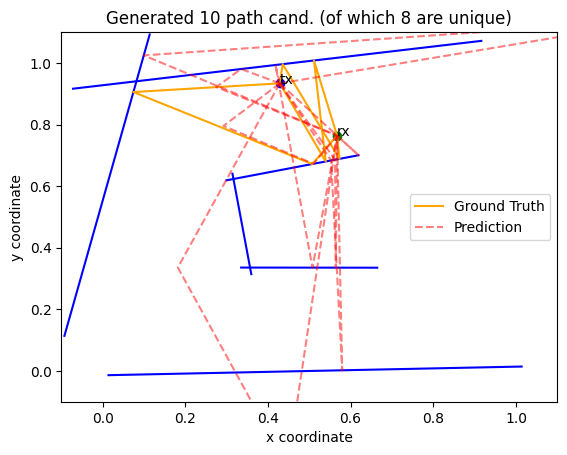

Array(180.70027, dtype=float32)

In [11]:
# Run this cell multiple times for different results!

key, key_loss_untrained = jax.random.split(key, 2)
loss(
    untrained_model, next(train_samples), plot=True, order=order, key=key_loss_untrained
)  # Untrained model

## Training phase

In the proposed architecture, only the `FlowModel` needs to be trained.

As a result, we defined a loss function directly deals with this model,
and not with the `Model` class, and the learning procedure looks a bit
like in the graph below.

```{mermaid}
:align: center
:caption: Graph of the (simplified) learning process.

graph LR
    GE[[Geometry]]
    PC((Flow<br>model))
    R(Reward)
    G(Gradients)

    subgraph Loss
        PC
        R
    end

    PC --> |order times| PC
    GE --> PC
    PC -->|"Path candidate"| R
    R --> |Loss| G
    G -->|Update| PC
```

The training function is very simple, as it the complex part
of performing the gradients update is done by {mod}`optax`.
We decide to use one of the most popular model, Adam {cite}`adam`,
but one could think of other optimizers (or meta-parameters)
that may be best suited to this problem!

In [12]:
optim = optax.adam(learning_rate=3e-5)

In [13]:
def train(
    model: FlowModel,
    train_samples: Iterator[Float[Array, "2+num_walls*2 2"]],
    val_samples: list[Float[Array, "2+num_walls*2 2"]],
    optim: optax.GradientTransformation,
    steps: int = 1000,
    print_every: int = 100,
    *,
    order: int,
    key: PRNGKeyArray,
) -> tuple[
    FlowModel,
    Float[Array, "{steps}//{print_every}"],
    Float[Array, "{steps}//{print_every}"],
    Float[Array, "{steps}//{print_every}"],
]:
    """
    Trains a flow model on a sequence of training samples and returns the averaged loss over validation samples.

    :param model: The model to train.
    :param train_samples: The training samples.
    :param val_samples: The validation samples.
    :param optim: The optimizer to use.
    :param steps: The number of optimization steps.
    :param print_every: The frequency at which the average loss is computed.
    :param order: The order of the paths to be trained on.
    :param key: The random key to be used.
    :return: The trained model, the steps,
        the train losses and the validation losses.
    """
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: FlowModel,
        opt_state: optax.OptState,
        xys: Float[Array, "2+num_walls*2 2"],
        *,
        order: int,
        key: PRNGKeyArray,
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(
            model, xys, order=order, key=key
        )
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    loss_steps = []
    train_losses = []
    val_losses = []
    jitted_loss = eqx.filter_jit(loss)

    with trange(steps, desc="", unit=" steps", leave=True) as bar:
        for (
            step,
            xys_train,
        ) in zip(bar, train_samples):
            key, key_step = jax.random.split(key, 2)

            model, opt_state, train_loss = make_step(
                model, opt_state, xys_train, order=order, key=key_step
            )

            if (step % print_every) == 0 or (step == steps - 1):
                # Only update the training 'bar' every few steps
                val_loss = 0.0
                for xys_val in val_samples:
                    key, key_val = jax.random.split(key, 2)
                    val_loss += jitted_loss(model, xys_val, order=order, key=key_val)

                val_loss /= len(val_samples)

                loss_steps.append(step)
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                bar.set_description(
                    f"train_loss = {float(train_loss):.1f}, "
                    f"val_loss = {float(val_loss):.1f}"
                )

    return model, jnp.array(loss_steps), jnp.array(train_losses), jnp.array(val_losses)

### Fixed order paths

Below, we show the training process for learning how to sample fixed order
path candidates. As you can see from the plot of the loss function,
the learning is not excellent, but we can observe that the model
often returns valid path candidates, and that we don't just have
`batch_size=10` random path candidates that are all different.

  0%|          | 0/1000 [00:00<?, ? steps/s]

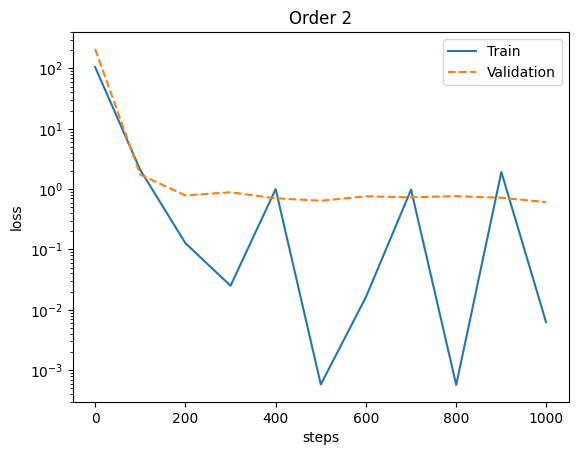

In [14]:
key, key_train = jax.random.split(key, 2)

trained_model, steps, train_losses, val_losses = train(
    untrained_model, train_samples, val_samples, optim, order=order, key=key_train
)

plt.semilogy(steps, train_losses, label="Train")
plt.semilogy(steps, val_losses, "--", label="Validation")
plt.title(f"Order {order}")
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()

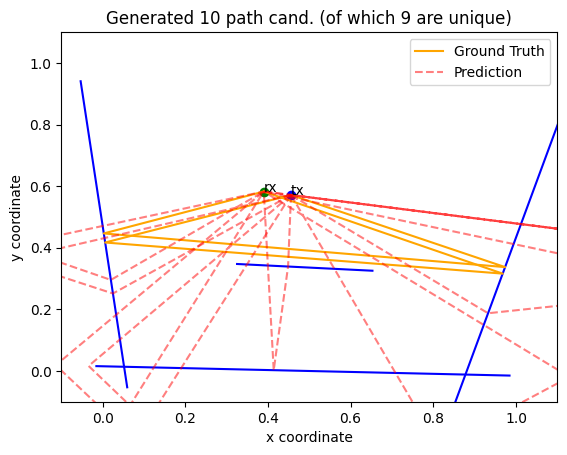

Array(0.03983746, dtype=float32)

In [19]:
key, key_loss_trained = jax.random.split(key, 2)

loss(
    trained_model, next(train_samples), plot=True, order=order, key=key_loss_trained
)

## Inference phase

Once the model has been trained, we can instantiate a complete Machine Learning
model to sample path candidates. In itself, the `Model` class is just a plan
wrapper around the trained `FlowModel` instance, that will call
it repeatedly to generate path candidates of a given size.

In [16]:
model = Model(
    flow=eqx.nn.inference_mode(
        trained_model
    )  # Here, this is a no-op (just copies the model)
)

In [17]:
# Run this cell multiple times for different results!

key, key_inference = jax.random.split(key, 2)

model(next(train_samples), order=order, key=key_inference)

Array([5, 2], dtype=int32)

=(discussion)
## Discussion

In complement to what is discussed in our paper, we highlight the following 
future prospects:
- removing from the training data the scenes that **do not contain any valid path**:
  they are not actually very interesting for our problem, and may have a detrimental impact on the
  learning process as the model will not receive any reward;
- to enhance generalization, we also could think of accumulating the loss on several scenes, rather than one scene at a time;
- and investigate a solution that aims to mitigate to impact of sparse reward functions, as in our case.